<a href="https://colab.research.google.com/github/harshitha-0531/-Next-Gen-Forecasting-Applying-Deep-Learning-to-Time-Series-Data/blob/main/Day13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import Libraries and Load Data
Import all required libraries and load the dataset (`data.csv`).


In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from copy import deepcopy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import kagglehub

# Download dataset
path = kagglehub.dataset_download("ashishjangra27/nifty-50-25-yrs-data")
print("Path to dataset files:", path)

# Read CSV from the downloaded folder
df = pd.read_csv(f"{path}/data.csv")

# Show first few rows
print(df.head())


Using Colab cache for faster access to the 'nifty-50-25-yrs-data' dataset.
Path to dataset files: /kaggle/input/nifty-50-25-yrs-data
         Date     Open     High      Low   Close
0  2000-01-03  1482.15  1592.90  1482.15  1592.2
1  2000-01-04  1594.40  1641.95  1594.40  1638.7
2  2000-01-05  1634.55  1635.50  1555.05  1595.8
3  2000-01-06  1595.80  1639.00  1595.80  1617.6
4  2000-01-07  1616.60  1628.25  1597.20  1613.3


 ### 2. Data Preparation

 ### 2. Create Input–Output Pairs
Generate sliding windows of past prices (30, 60, 90 days) using the **High** column.  
Save them in `chunked_data` as `X_High_30`, `y_High_30`, etc.


In [ ]:
def return_pairs(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i:i+days])
        y.append(pricess[i+days])
    return np.array(X), np.array(y)

target_column =  'High'
day_chunks =  [30, 60, 90]

chunked_data = {}

for days in day_chunks:
    key_X = f"X_{target_column}_{days}"
    key_y = f"y_{target_column}_{days}"
    X, y = return_pairs(df[target_column], days)
    chunked_data[key_X] = X
    chunked_data[key_y] = y

chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

### List of Models
- ML → **KNN**  
- DL → **RNN, LSTM, GRU, BiLSTM**



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional
from sklearn.neighbors import KNeighborsRegressor


def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model



## 📑 Model Collections

### 1. Traditional ML Models
We include only the **KNN Regressor** for the classical machine learning approach:  

- `ml_models`: a list of tuples `(name, model_instance)`  
  - **KNN** → `KNeighborsRegressor`  

---

### 2. Deep Learning Models
We define a dictionary mapping model names to their corresponding builder functions. Each builder function takes an `input_shape` and returns a compiled neural network:

- `dl_models`: {name → builder function}  
  - `"RNN"` → `build_rnn`  
  - `"LSTM"` → `build_lstm`  
  - `"GRU"` → `build_gru`  
  - `"Bidirectional_LSTM"` → `build_bilstm`  

---

### 3. Purpose
- `ml_models` → ready-to-train **classical ML regressors**.  
- `dl_models` → reusable functions that return compiled **deep learning models** for sequential regression.


In [ ]:
ml_models = [
    ("KNN", KNeighborsRegressor(n_neighbors=5))
]

dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}


### 5. Model Training

In [ ]:
trained_models = {}

for X_key, y_key in tqdm(chunk_pairs):
    X_data = chunked_data[X_key]
    y_data = chunked_data[y_key]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    for model_name, model in tqdm(ml_models, desc=f"Training ML models for {X_key}"):
        key = model_name + '_' + X_key.split('_')[-1]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items(), desc=f"Training DL models for {X_key}"):
        key = model_name + '_' + X_key.split('_')[-1]
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=50, batch_size=8, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

  0%|          | 0/3 [00:00<?, ?it/s]

Training ML models for X_High_30:   0%|          | 0/1 [00:00<?, ?it/s]

Training DL models for X_High_30:   0%|          | 0/4 [00:00<?, ?it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Training ML models for X_High_60:   0%|          | 0/1 [00:00<?, ?it/s]

Training DL models for X_High_60:   0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Training ML models for X_High_90:   0%|          | 0/1 [00:00<?, ?it/s]

Training DL models for X_High_90:   0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


**Saving Model Statistics**
Collect Results

Convert the trained_models dictionary into a list of dictionaries, where each dictionary contains the model's name and its performance metrics.

Create DataFrame

Create a pandas DataFrame from the collected results.

The DataFrame will include columns for Model, train_mae, train_rmse, test_mae, and test_rmse.

Sort Results

Sort the DataFrame in ascending order based on the test_mae column to identify the best-performing models.

Display

Display the sorted DataFrame to show the top models.

In [ ]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True).head(50)

,Model,model,train_mae,train_rmse,test_mae,test_rmse
10,KNN_90,KNeighborsRegressor(),36.929140,58.769966,48.790144,74.204848
5,KNN_60,KNeighborsRegressor(),36.850899,58.333589,52.819089,82.674612
0,KNN_30,KNeighborsRegressor(),42.646429,68.669169,56.933037,89.679421
1,RNN_30,"<Sequential name=sequential_1, built=True>",6388.265509,8842.204816,5891.126739,8445.744446
6,RNN_60,"<Sequential name=sequential_5, built=True>",6418.876444,8877.846459,5963.476138,8380.426668
11,RNN_90,"<Sequential name=sequential_9, built=True>",6462.427493,8911.140832,6183.129201,8627.690402
3,GRU_30,"<Sequential name=sequential_3, built=True>",6837.741525,9271.581440,6320.231709,8859.445076
4,Bidirectional_LSTM_30,"<Sequential name=sequential_4, built=True>",6990.600204,9392.590715,6471.549099,8976.556974
8,GRU_60,"<Sequential name=sequential_7, built=True>",6991.375628,9404.550034,6509.978174,8897.265837
14,Bidirectional_LSTM_90,"<Sequential name=sequential_12, built=True>",6876.844138,9304.181078,6579.779586,9014.997906


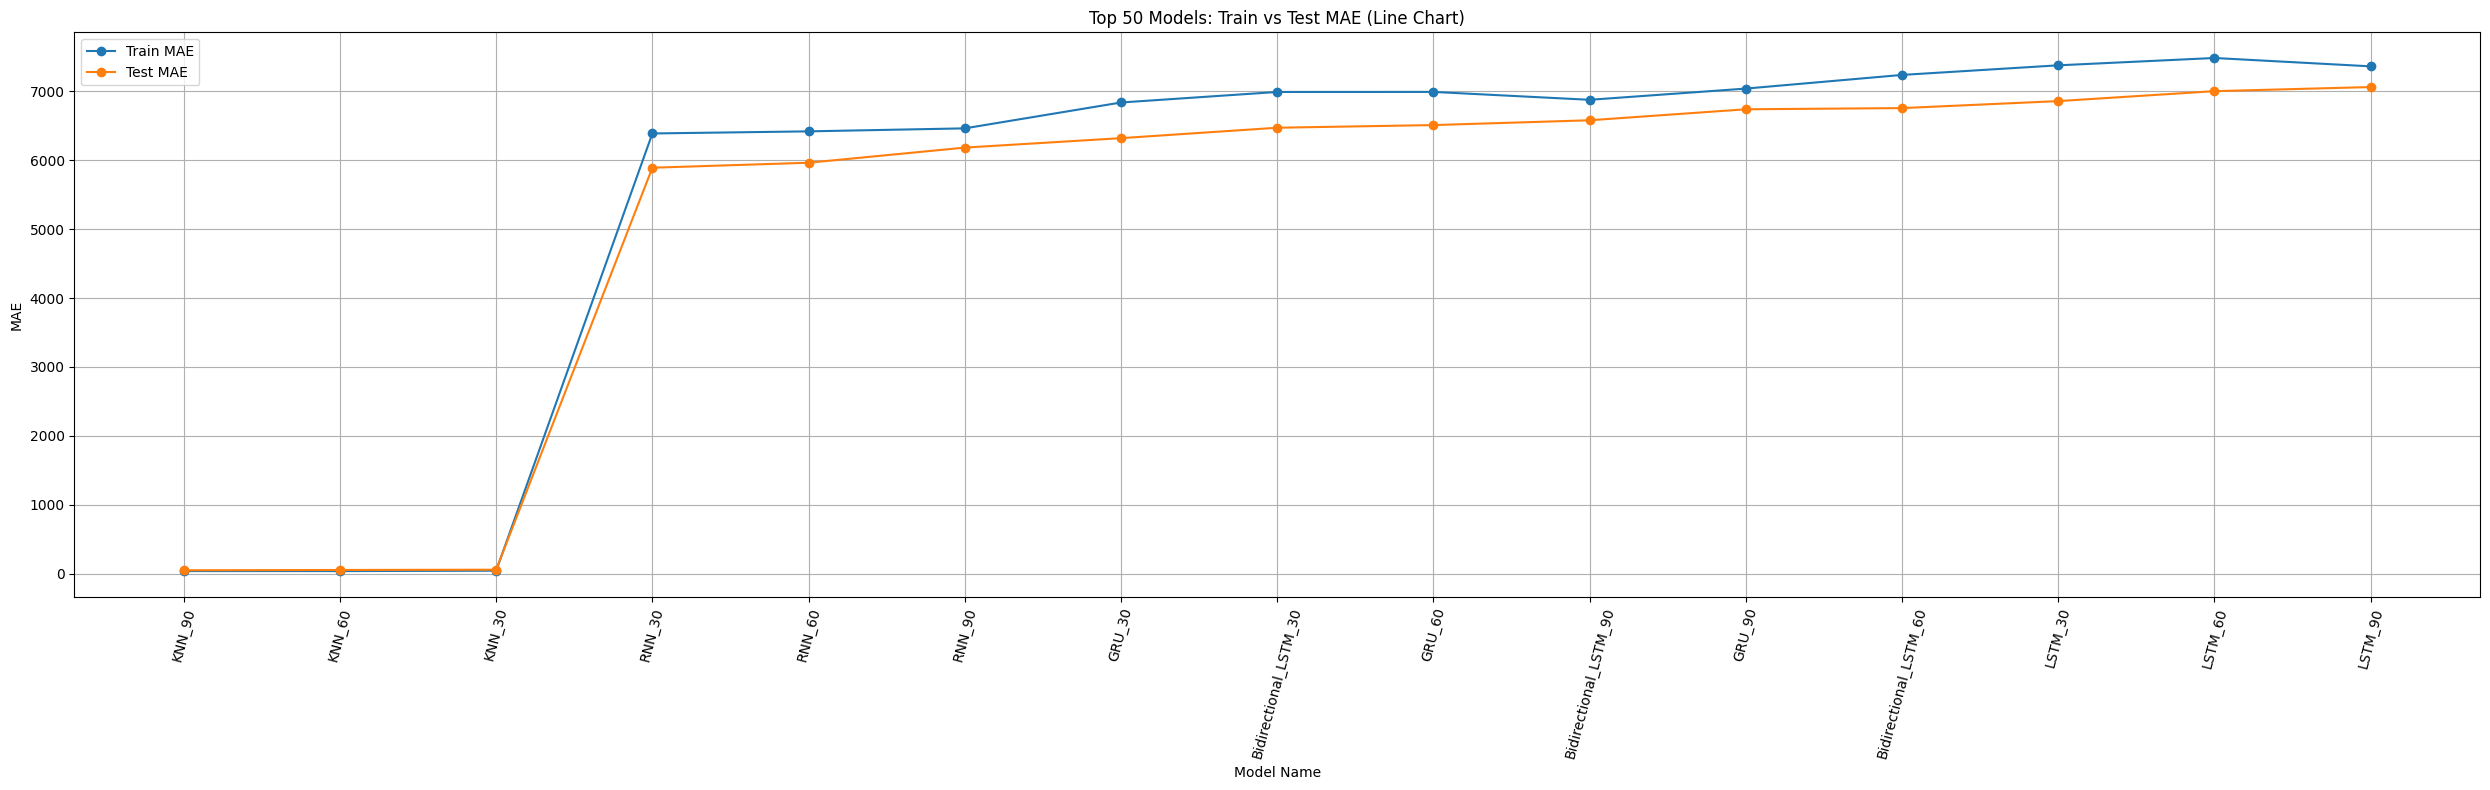

In [ ]:
import matplotlib.pyplot as plt

top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)

plt.figure(figsize=(25, 8))
plt.plot(top_50['Model'], top_50['train_mae'], marker='o', label='Train MAE')

plt.plot(top_50['Model'], top_50['test_mae'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('Top 50 Models: Train vs Test MAE (Line Chart)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


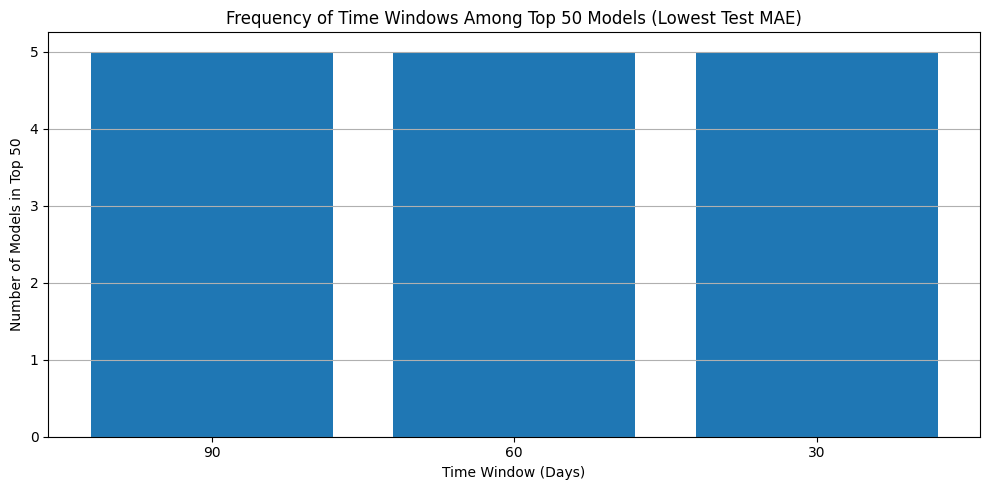

In [ ]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
time_windows = pd.Series([i.split('_')[-1] for i in top_50['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)  # Sort by count

plt.figure(figsize=(10, 5))
plt.bar(time_counts.index, time_counts.values)

plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models in Top 50')
plt.title('Frequency of Time Windows Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

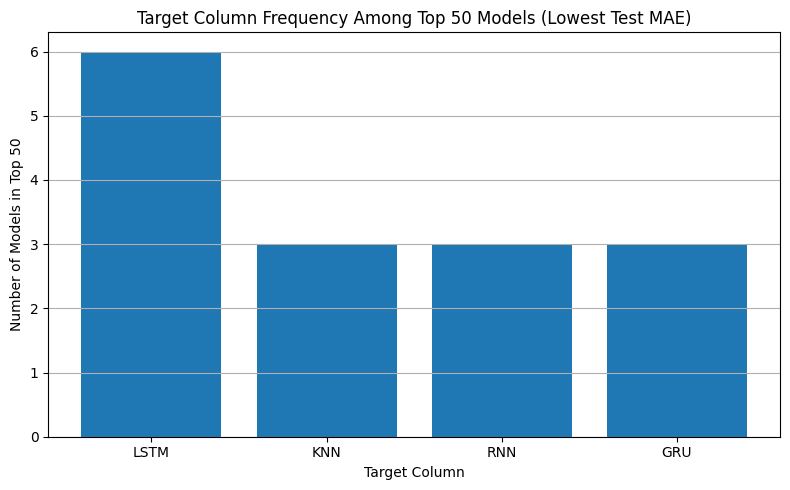

In [ ]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
target_columns = pd.Series([i.split('_')[-2] for i in top_50['Model']])
target_counts = target_columns.value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values)

plt.xlabel('Target Column')
plt.ylabel('Number of Models in Top 50')
plt.title('Target Column Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 10. Which model works in general better on this task?

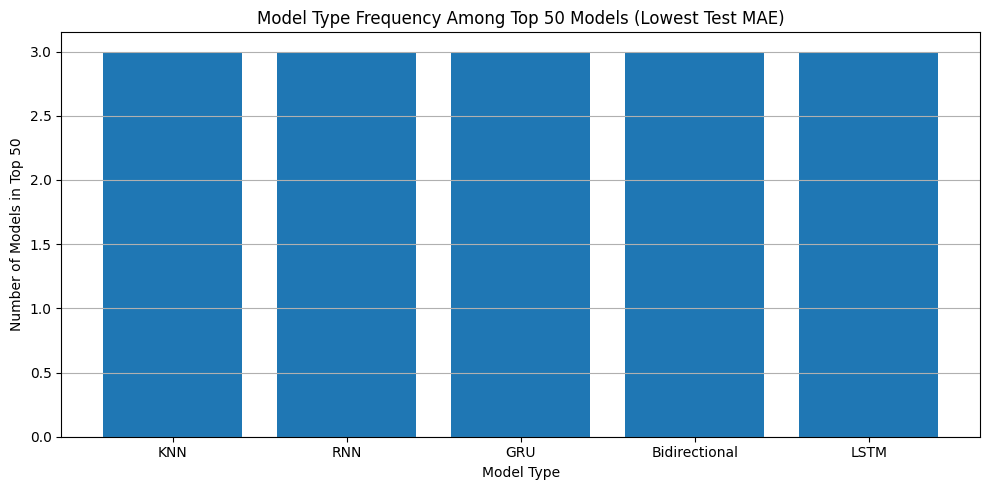

In [ ]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
model_types = pd.Series([i.split('_')[0] for i in top_50['Model']])
model_counts = model_types.value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(model_counts.index, model_counts.values)

# Labels and aesthetics
plt.xlabel('Model Type')
plt.ylabel('Number of Models in Top 50')
plt.title('Model Type Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Saving Models

In [ ]:
import joblib

results_df.to_csv('models.csv')
joblib.dump(trained_models, 'trained_models.joblib')

loaded_models = joblib.load('trained_models.joblib')

In [ ]:
model = loaded_models['KNN_90']['model']
print(chunked_data.keys())



dict_keys(['X_High_30', 'y_High_30', 'X_High_60', 'y_High_60', 'X_High_90', 'y_High_90'])


In [ ]:
print(chunked_data['X_High_90'][5])
print(model.predict([chunked_data['X_High_90'][5]]))


[1662.1  1639.9  1631.55 1671.15 1627.4  1668.45 1615.15 1644.45 1644.4
 1626.5  1645.   1613.65 1633.55 1610.9  1598.35 1554.15 1605.9  1616.7
 1621.35 1645.9  1676.1  1731.65 1713.7  1771.65 1795.45 1744.5  1742.8
 1753.1  1764.15 1767.8  1781.05 1818.15 1751.6  1757.05 1726.65 1783.3
 1727.9  1773.85 1719.15 1721.   1730.85 1765.25 1692.25 1680.45 1645.
 1571.3  1630.95 1621.2  1585.25 1604.   1629.2  1579.4  1593.3  1575.85
 1609.4  1557.85 1545.55 1555.5  1534.05 1467.4  1475.25 1558.05 1636.95
 1631.6  1628.55 1587.95 1518.55 1478.85 1469.05 1425.55 1431.8  1383.8
 1439.05 1455.85 1438.   1421.5  1342.15 1385.15 1428.6  1436.6  1385.7
 1391.35 1359.1  1326.3  1311.7  1310.45 1347.7  1316.2  1293.45 1267.85]
[1261.65]
